# Ablation Study 2.1: Multiple Timesteps vs. Single Timestep

## Motivation

The original paper's claim that single-timestep training outperforms multi-timestep training is counterintuitive. This ablation re-examines whether the observed superiority arises from optimization difficulty, overfitting, or an intrinsic property of SpikePoint's architecture.

## Dataset Setup

Before running this notebook, ensure the ModelNet40 dataset is downloaded and extracted to: `data/modelnet40_normal_resampled/`

In [1]:
import os
import sys
import torch
import numpy as np
import datetime
import importlib
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append('..')
from data_utils.ModelNetDataLoader import ModelNetDataLoader
from models.spike_model import SpikeModel
import provider

print('Imports successful!')
from cache_utils import load_training_history, save_training_history, cache_checkpoint, load_cached_checkpoint_path, best_metric
from viz_utils import plot_training_curves, summarize_histories, plot_metric_table, plot_metric_bars


Imports successful!


## Configuration

In [2]:
class Args:
    def __init__(self, step=1, num_category=40):
        self.use_cpu = False
        self.gpu = '0'
        self.batch_size = 24
        self.model = 'pointnet_cls'
        self.num_category = num_category
        self.epoch = 200
        self.learning_rate = 0.001
        self.num_point = 1024
        self.optimizer = 'Adam'
        self.log_dir = f'ablation_step{step}_modelnet{num_category}'
        self.decay_rate = 1e-4
        self.use_normals = False
        self.process_data = False
        self.use_uniform_sample = False
        self.step = step
        self.spike = True
        self.temp = 5.0

args_step1 = Args(step=1, num_category=40)
args_step4 = Args(step=4, num_category=40)
print(f'Config step=1: {args_step1.log_dir}')
print(f'Config step=4: {args_step4.log_dir}')

Config step=1: ablation_step1_modelnet40
Config step=4: ablation_step4_modelnet40


## Helper Functions

In [3]:
def setup_experiment(args):
    os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
    exp_dir = Path('../log/classification') / args.log_dir
    exp_dir.mkdir(parents=True, exist_ok=True)
    checkpoints_dir = exp_dir / 'checkpoints'
    checkpoints_dir.mkdir(exist_ok=True)
    return exp_dir, checkpoints_dir

def load_data(args):
    data_path = 'C:\\Users\\VIICTTE\\ML_Project\\modelnet40_normal_resampled'
    train_dataset = ModelNetDataLoader(root=data_path, args=args, split='train')
    test_dataset = ModelNetDataLoader(root=data_path, args=args, split='test')
    trainDataLoader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4, drop_last=True)
    testDataLoader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)
    return trainDataLoader, testDataLoader

def create_model(args):
    sys.path.append('../models')
    model = importlib.import_module(args.model)
    classifier = model.get_model(args.num_category, normal_channel=args.use_normals)
    if args.spike:
        classifier = SpikeModel(classifier, args.step, args.temp)
        classifier.set_spike_state(True)
    criterion = model.get_loss()
    if not args.use_cpu:
        classifier = classifier.cuda()
        criterion = criterion.cuda()
    return classifier, criterion

print('Helper functions defined!')

Helper functions defined!


## Training Function

In [4]:
def train_model(args, exp_dir, checkpoints_dir, max_epochs=None):
    if max_epochs:
        args.epoch = max_epochs
    trainDataLoader, testDataLoader = load_data(args)
    classifier, criterion = create_model(args)
    
    optimizer = torch.optim.Adam(classifier.parameters(), lr=args.learning_rate, weight_decay=args.decay_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)
    
    best_acc = 0.0
    history = []
    
    for epoch in range(args.epoch):
        print(f'Epoch {epoch+1}/{args.epoch}')
        classifier.train()
        scheduler.step()
        mean_correct = []
        
        for points, target in tqdm(trainDataLoader):
            optimizer.zero_grad()
            points = points.data.numpy()
            points = provider.random_point_dropout(points)
            points[:,:,0:3] = provider.random_scale_point_cloud(points[:,:,0:3])
            points[:,:,0:3] = provider.shift_point_cloud(points[:,:,0:3])
            points = torch.Tensor(points).transpose(2, 1)
            if not args.use_cpu:
                points, target = points.cuda(), target.cuda()
            pred, trans_feat = classifier(points)
            loss = criterion(pred, target.long(), trans_feat)
            loss.backward()
            optimizer.step()
            pred_choice = pred.data.max(1)[1]
            correct = pred_choice.eq(target.long().data).cpu().sum()
            mean_correct.append(correct.item() / float(points.size()[0]))
        
        train_acc = np.mean(mean_correct)
        
        with torch.no_grad():
            classifier.eval()
            test_correct = []
            for points, target in testDataLoader:
                if not args.use_cpu:
                    points, target = points.cuda(), target.cuda()
                points = points.transpose(2, 1)
                pred, _ = classifier(points)
                pred_choice = pred.data.max(1)[1]
                correct = pred_choice.eq(target.long().data).cpu().sum()
                test_correct.append(correct.item() / float(points.size()[0]))
            test_acc = np.mean(test_correct)
        
        print(f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        history.append({'epoch': epoch+1, 'train_acc': train_acc, 'test_acc': test_acc})
        
        if test_acc >= best_acc:
            best_acc = test_acc
            torch.save({'model_state_dict': classifier.state_dict()}, str(checkpoints_dir / 'best_model.pth'))
    
    return classifier, history, best_acc

print('Training function defined!')

Training function defined!


## Train Models

**Note**: Training takes significant time. Consider reducing epochs for testing.

In [5]:
# Load cached baseline (step=1) run if available, otherwise train
BASELINE_CACHE_NAME = 'baseline_step_1'
baseline_history, baseline_meta = load_training_history(BASELINE_CACHE_NAME, with_metadata=True)
if baseline_history:
    print(f"Loaded cached baseline history with {len(baseline_history)} epoch(s) from {BASELINE_CACHE_NAME}.json")
    history1 = baseline_history
    best_acc1 = best_metric(history1, ['test_acc', 'test_instance_acc']) or 0.0
    classifier1 = None
    cached_ckpt_path = load_cached_checkpoint_path(BASELINE_CACHE_NAME)
    if cached_ckpt_path:
        print(f'Cached baseline checkpoint available at: {cached_ckpt_path}')
else:
    print('No cached baseline history found; training step=1 baseline from scratch.')
    exp_dir1, ckpt_dir1 = setup_experiment(args_step1)
    classifier1, history1, best_acc1 = train_model(args_step1, exp_dir1, ckpt_dir1, max_epochs=10)  # Reduce to 10 for testing
    metadata1 = {
        'variant': 'baseline_step_1',
        'config': dict(vars(args_step1)),
        'max_epochs': args_step1.epoch,
    }
    history_path1 = save_training_history(history1, BASELINE_CACHE_NAME, metadata=metadata1)
    print(f'Saved baseline history to {history_path1}')
    best_ckpt1 = ckpt_dir1 / 'best_model.pth'
    if best_ckpt1.exists():
        cached_ckpt_path = cache_checkpoint(best_ckpt1, BASELINE_CACHE_NAME)
        print(f'Cached baseline checkpoint to {cached_ckpt_path}')
print(f'Step=1 Best Accuracy: {best_acc1:.4f}')

Loaded cached baseline history with 200 epoch(s) from baseline_step_1.json
Cached baseline checkpoint available at: ..\artifacts\spikepointnet\checkpoints\baseline_step_1.pth
Step=1 Best Accuracy: 0.8818


In [7]:
# Train with step=4
exp_dir4, ckpt_dir4 = setup_experiment(args_step4)
classifier4, history4, best_acc4 = train_model(args_step4, exp_dir4, ckpt_dir4, max_epochs=200)  # Reduce to 10 for testing
print(f'Step=4 Best Accuracy: {best_acc4:.4f}')

The size of train data is 9843
The size of test data is 2468
Epoch 1/200


100%|██████████████████████████████████████████████████████████████████| 410/410 [01:06<00:00,  6.14it/s]


Train Acc: 0.5060, Test Acc: 0.0405
Epoch 2/200


100%|██████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.31it/s]


Train Acc: 0.6304, Test Acc: 0.0405
Epoch 3/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.34it/s]


Train Acc: 0.5484, Test Acc: 0.0113
Epoch 4/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.3860, Test Acc: 0.0121
Epoch 5/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.4744, Test Acc: 0.1072
Epoch 6/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.4920, Test Acc: 0.3147
Epoch 7/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.5089, Test Acc: 0.0821
Epoch 8/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.5004, Test Acc: 0.2031
Epoch 9/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.5263, Test Acc: 0.1545
Epoch 10/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.5397, Test Acc: 0.0740
Epoch 11/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.33it/s]


Train Acc: 0.5530, Test Acc: 0.4858
Epoch 12/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.5392, Test Acc: 0.1824
Epoch 13/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.5287, Test Acc: 0.0736
Epoch 14/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.4833, Test Acc: 0.2658
Epoch 15/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.5151, Test Acc: 0.3139
Epoch 16/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.34it/s]


Train Acc: 0.5389, Test Acc: 0.5186
Epoch 17/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.5572, Test Acc: 0.2739
Epoch 18/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.34it/s]


Train Acc: 0.5792, Test Acc: 0.2544
Epoch 19/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.6001, Test Acc: 0.2075
Epoch 20/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.34it/s]


Train Acc: 0.6193, Test Acc: 0.3629
Epoch 21/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.6297, Test Acc: 0.3596
Epoch 22/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.6355, Test Acc: 0.4773
Epoch 23/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.6338, Test Acc: 0.3936
Epoch 24/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.6539, Test Acc: 0.3206
Epoch 25/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.6675, Test Acc: 0.6274
Epoch 26/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.34it/s]


Train Acc: 0.6794, Test Acc: 0.6193
Epoch 27/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.34it/s]


Train Acc: 0.6922, Test Acc: 0.6885
Epoch 28/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.33it/s]


Train Acc: 0.7001, Test Acc: 0.6824
Epoch 29/200


100%|██████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.31it/s]


Train Acc: 0.7088, Test Acc: 0.7116
Epoch 30/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.34it/s]


Train Acc: 0.7034, Test Acc: 0.7155
Epoch 31/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.7078, Test Acc: 0.3167
Epoch 32/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.7295, Test Acc: 0.6259
Epoch 33/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.7307, Test Acc: 0.6671
Epoch 34/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.7287, Test Acc: 0.5157
Epoch 35/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.7295, Test Acc: 0.5472
Epoch 36/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.7297, Test Acc: 0.3576
Epoch 37/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.7388, Test Acc: 0.7486
Epoch 38/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.7370, Test Acc: 0.4872
Epoch 39/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.7324, Test Acc: 0.6096
Epoch 40/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.7505, Test Acc: 0.6868
Epoch 41/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.7543, Test Acc: 0.7722
Epoch 42/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.7660, Test Acc: 0.5632
Epoch 43/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.7759, Test Acc: 0.7507
Epoch 44/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.7843, Test Acc: 0.7681
Epoch 45/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.7787, Test Acc: 0.7888
Epoch 46/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.7816, Test Acc: 0.7835
Epoch 47/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.7873, Test Acc: 0.7783
Epoch 48/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:05<00:00,  6.27it/s]


Train Acc: 0.7932, Test Acc: 0.8001
Epoch 49/200


100%|██████████████████████████████████████████████████████████████████| 410/410 [01:05<00:00,  6.31it/s]


Train Acc: 0.8002, Test Acc: 0.8131
Epoch 50/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8001, Test Acc: 0.7992
Epoch 51/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.8016, Test Acc: 0.7986
Epoch 52/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.7971, Test Acc: 0.7998
Epoch 53/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8079, Test Acc: 0.8253
Epoch 54/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8130, Test Acc: 0.8321
Epoch 55/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.8125, Test Acc: 0.6920
Epoch 56/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.8148, Test Acc: 0.8070
Epoch 57/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.8180, Test Acc: 0.8139
Epoch 58/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8201, Test Acc: 0.8197
Epoch 59/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8206, Test Acc: 0.8079
Epoch 60/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8280, Test Acc: 0.8394
Epoch 61/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8352, Test Acc: 0.8459
Epoch 62/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8337, Test Acc: 0.8380
Epoch 63/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8343, Test Acc: 0.8372
Epoch 64/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8331, Test Acc: 0.8287
Epoch 65/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.8410, Test Acc: 0.8436
Epoch 66/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8407, Test Acc: 0.8278
Epoch 67/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8424, Test Acc: 0.8055
Epoch 68/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8497, Test Acc: 0.8399
Epoch 69/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8434, Test Acc: 0.7452
Epoch 70/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.37it/s]


Train Acc: 0.8455, Test Acc: 0.8370
Epoch 71/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8497, Test Acc: 0.8451
Epoch 72/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.8462, Test Acc: 0.8262
Epoch 73/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8524, Test Acc: 0.8365
Epoch 74/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:05<00:00,  6.30it/s]


Train Acc: 0.8573, Test Acc: 0.8532
Epoch 75/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8508, Test Acc: 0.8221
Epoch 76/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8606, Test Acc: 0.8407
Epoch 77/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.8569, Test Acc: 0.8307
Epoch 78/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.8629, Test Acc: 0.8396
Epoch 79/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8606, Test Acc: 0.8451
Epoch 80/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.8670, Test Acc: 0.8540
Epoch 81/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8641, Test Acc: 0.8606
Epoch 82/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.34it/s]


Train Acc: 0.8732, Test Acc: 0.8533
Epoch 83/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.8727, Test Acc: 0.8646
Epoch 84/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8731, Test Acc: 0.8645
Epoch 85/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8807, Test Acc: 0.8356
Epoch 86/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8758, Test Acc: 0.8586
Epoch 87/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8771, Test Acc: 0.8650
Epoch 88/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8811, Test Acc: 0.8546
Epoch 89/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8751, Test Acc: 0.8646
Epoch 90/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8799, Test Acc: 0.8708
Epoch 91/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8788, Test Acc: 0.8586
Epoch 92/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8787, Test Acc: 0.8679
Epoch 93/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8804, Test Acc: 0.8658
Epoch 94/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8787, Test Acc: 0.8384
Epoch 95/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8816, Test Acc: 0.8528
Epoch 96/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8845, Test Acc: 0.8735
Epoch 97/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.8839, Test Acc: 0.8693
Epoch 98/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.8817, Test Acc: 0.8042
Epoch 99/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8870, Test Acc: 0.8672
Epoch 100/200


100%|██████████████████████████████████████████████████████████████████| 410/410 [01:05<00:00,  6.31it/s]


Train Acc: 0.8927, Test Acc: 0.8595
Epoch 101/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8910, Test Acc: 0.8456
Epoch 102/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.37it/s]


Train Acc: 0.8929, Test Acc: 0.8647
Epoch 103/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.37it/s]


Train Acc: 0.8923, Test Acc: 0.8618
Epoch 104/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.37it/s]


Train Acc: 0.8951, Test Acc: 0.8715
Epoch 105/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8961, Test Acc: 0.3511
Epoch 106/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.8963, Test Acc: 0.8638
Epoch 107/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8958, Test Acc: 0.8725
Epoch 108/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.35it/s]


Train Acc: 0.8971, Test Acc: 0.8744
Epoch 109/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8954, Test Acc: 0.8707
Epoch 110/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8948, Test Acc: 0.8693
Epoch 111/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8982, Test Acc: 0.8548
Epoch 112/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8956, Test Acc: 0.8477
Epoch 113/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8975, Test Acc: 0.8770
Epoch 114/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.37it/s]


Train Acc: 0.9002, Test Acc: 0.8830
Epoch 115/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8990, Test Acc: 0.8854
Epoch 116/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.37it/s]


Train Acc: 0.9021, Test Acc: 0.8302
Epoch 117/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8993, Test Acc: 0.8723
Epoch 118/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.8997, Test Acc: 0.8691
Epoch 119/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.37it/s]


Train Acc: 0.9014, Test Acc: 0.8706
Epoch 120/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.9058, Test Acc: 0.8774
Epoch 121/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.37it/s]


Train Acc: 0.9035, Test Acc: 0.8706
Epoch 122/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.37it/s]


Train Acc: 0.9015, Test Acc: 0.8753
Epoch 123/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.9045, Test Acc: 0.8809
Epoch 124/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.37it/s]


Train Acc: 0.9045, Test Acc: 0.8804
Epoch 125/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.37it/s]


Train Acc: 0.9056, Test Acc: 0.8746
Epoch 126/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:05<00:00,  6.30it/s]


Train Acc: 0.9093, Test Acc: 0.8699
Epoch 127/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.9057, Test Acc: 0.8790
Epoch 128/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.9089, Test Acc: 0.8761
Epoch 129/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.9079, Test Acc: 0.8775
Epoch 130/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.9110, Test Acc: 0.8825
Epoch 131/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.9132, Test Acc: 0.8788
Epoch 132/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.9078, Test Acc: 0.8762
Epoch 133/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.9118, Test Acc: 0.8826
Epoch 134/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.9088, Test Acc: 0.8832
Epoch 135/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.36it/s]


Train Acc: 0.9087, Test Acc: 0.8802
Epoch 136/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:06<00:00,  6.21it/s]


Train Acc: 0.9082, Test Acc: 0.8822
Epoch 137/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:05<00:00,  6.25it/s]


Train Acc: 0.9080, Test Acc: 0.6183
Epoch 138/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:05<00:00,  6.23it/s]


Train Acc: 0.9058, Test Acc: 0.8682
Epoch 139/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9089, Test Acc: 0.8752
Epoch 140/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9111, Test Acc: 0.8841
Epoch 141/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9155, Test Acc: 0.8832
Epoch 142/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.31it/s]


Train Acc: 0.9146, Test Acc: 0.8773
Epoch 143/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9133, Test Acc: 0.8871
Epoch 144/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.33it/s]


Train Acc: 0.9132, Test Acc: 0.8846
Epoch 145/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9139, Test Acc: 0.8793
Epoch 146/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9124, Test Acc: 0.8858
Epoch 147/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9175, Test Acc: 0.8763
Epoch 148/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.33it/s]


Train Acc: 0.9143, Test Acc: 0.8812
Epoch 149/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.33it/s]


Train Acc: 0.9149, Test Acc: 0.8850
Epoch 150/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9147, Test Acc: 0.8807
Epoch 151/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9128, Test Acc: 0.8692
Epoch 152/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9157, Test Acc: 0.8780
Epoch 153/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9180, Test Acc: 0.8819
Epoch 154/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9203, Test Acc: 0.8861
Epoch 155/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9159, Test Acc: 0.8829
Epoch 156/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9182, Test Acc: 0.8891
Epoch 157/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9195, Test Acc: 0.8858
Epoch 158/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9213, Test Acc: 0.8807
Epoch 159/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9195, Test Acc: 0.8769
Epoch 160/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.33it/s]


Train Acc: 0.9205, Test Acc: 0.8897
Epoch 161/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9190, Test Acc: 0.8879
Epoch 162/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9222, Test Acc: 0.8820
Epoch 163/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9206, Test Acc: 0.8863
Epoch 164/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9231, Test Acc: 0.8833
Epoch 165/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.33it/s]


Train Acc: 0.9216, Test Acc: 0.8803
Epoch 166/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.33it/s]


Train Acc: 0.9200, Test Acc: 0.8850
Epoch 167/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9197, Test Acc: 0.8885
Epoch 168/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.31it/s]


Train Acc: 0.9244, Test Acc: 0.8791
Epoch 169/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9220, Test Acc: 0.8863
Epoch 170/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.33it/s]


Train Acc: 0.9207, Test Acc: 0.8871
Epoch 171/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9244, Test Acc: 0.8872
Epoch 172/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9205, Test Acc: 0.8826
Epoch 173/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9224, Test Acc: 0.8790
Epoch 174/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9236, Test Acc: 0.8849
Epoch 175/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9221, Test Acc: 0.8796
Epoch 176/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9241, Test Acc: 0.8845
Epoch 177/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.31it/s]


Train Acc: 0.9239, Test Acc: 0.8811
Epoch 178/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9230, Test Acc: 0.8823
Epoch 179/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9255, Test Acc: 0.8884
Epoch 180/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9255, Test Acc: 0.8856
Epoch 181/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:05<00:00,  6.31it/s]


Train Acc: 0.9270, Test Acc: 0.8863
Epoch 182/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.33it/s]


Train Acc: 0.9267, Test Acc: 0.8867
Epoch 183/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.33it/s]


Train Acc: 0.9248, Test Acc: 0.8905
Epoch 184/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9285, Test Acc: 0.8827
Epoch 185/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9253, Test Acc: 0.8920
Epoch 186/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9253, Test Acc: 0.8884
Epoch 187/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9276, Test Acc: 0.8871
Epoch 188/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9254, Test Acc: 0.8900
Epoch 189/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9258, Test Acc: 0.8917
Epoch 190/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9251, Test Acc: 0.8896
Epoch 191/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9239, Test Acc: 0.8916
Epoch 192/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9264, Test Acc: 0.8868
Epoch 193/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9282, Test Acc: 0.8846
Epoch 194/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9301, Test Acc: 0.8865
Epoch 195/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9279, Test Acc: 0.8867
Epoch 196/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9274, Test Acc: 0.8843
Epoch 197/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9272, Test Acc: 0.8799
Epoch 198/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9253, Test Acc: 0.8847
Epoch 199/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9262, Test Acc: 0.8812
Epoch 200/200


100%|██████████████████████████████████████████████████████████████████████| 410/410 [01:04<00:00,  6.32it/s]


Train Acc: 0.9300, Test Acc: 0.8885
Step=4 Best Accuracy: 0.8920


## Visualization

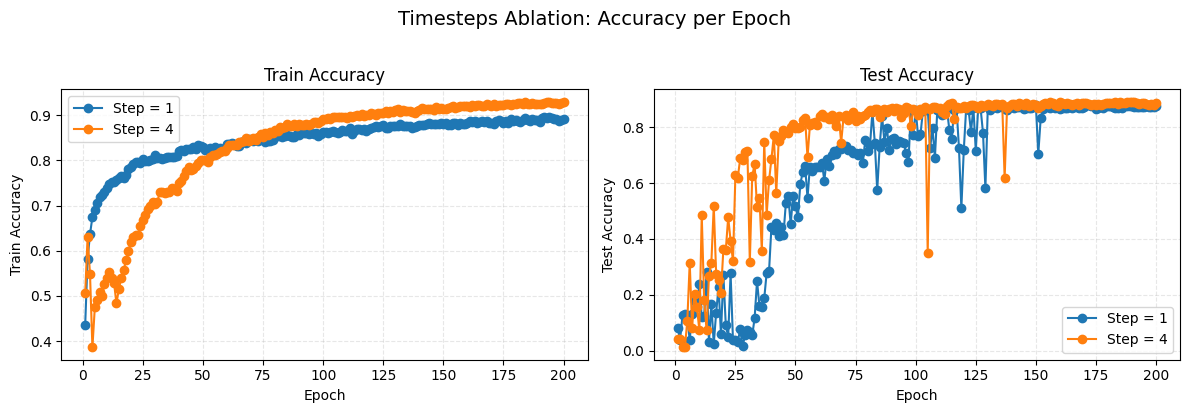

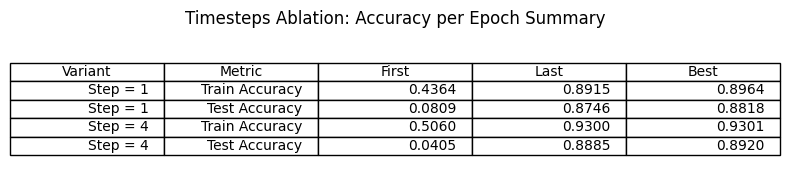

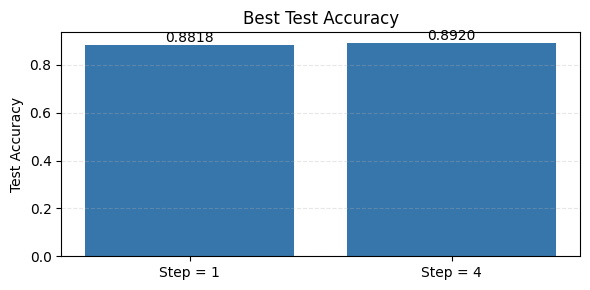

Detailed metrics:
  Step = 1: last={_fmt(stats.get('last'))}, best={_fmt(stats.get('best'))}
  Step = 4: last={_fmt(stats.get('last'))}, best={_fmt(stats.get('best'))}


In [9]:
import matplotlib.pyplot as plt
from pathlib import Path

metrics = {
    "Train Accuracy": ["train_acc"],
    "Test Accuracy": ["test_instance_acc", "test_acc"],
}

available_histories = {}
if 'history1' in locals() and history1:
    available_histories["Step = 1"] = history1
if 'history4' in locals() and history4:
    available_histories["Step = 4"] = history4

if not available_histories:
    print('No training history available for visualization. Run the training cells above first.')
else:
    fig, axes = plot_training_curves(
        available_histories,
        metrics,
        title="Timesteps Ablation: Accuracy per Epoch"
    )

    figures_dir = Path("../log/figures") / "timesteps"
    figures_dir.mkdir(parents=True, exist_ok=True)
    curve_path = figures_dir / "accuracy_curves.png"
    fig.savefig(curve_path, dpi=150, bbox_inches="tight")
    plt.show()

    summary_stats = summarize_histories(available_histories, metrics)
    table_fig, table_ax = plot_metric_table(
        summary_stats,
        title="Timesteps Ablation: Accuracy per Epoch Summary",
        value_fmt="{:.4f}",
        include_first=True
    )
    table_path = figures_dir / "accuracy_summary.png"
    table_fig.savefig(table_path, dpi=150, bbox_inches="tight")
    plt.show()

    bar_fig, bar_ax = plot_metric_bars(
        summary_stats,
        metric_name="Test Accuracy",
        title="Best Test Accuracy",
        ylabel="Test Accuracy"
    )
    bar_path = figures_dir / "best_accuracy.png"
    bar_fig.savefig(bar_path, dpi=150, bbox_inches="tight")
    plt.show()

    def _fmt(value):
        return "-" if value is None else f"{value:.4f}"

    print('Detailed metrics:')
    for label, metric_stats in summary_stats.items():
        stats = metric_stats.get("Test Accuracy", {})
        print(f"  {label}: last={{_fmt(stats.get('last'))}}, best={{_fmt(stats.get('best'))}}")


## Summary

Compare the results to understand whether single-timestep or multi-timestep training performs better. The paper claims single-timestep training outperforms multi-timestep training.